# Model - CIC IoT 2023 Dataset for Cybersecurity Research

[University of New Brunswick - Canadian Institute for Cybersecurity](https://www.unb.ca/cic/datasets/index.html)

## Imports

In [1]:
import os
import sys
import datetime
import operator as op

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython.display import HTML

sys.path.append('../')
n_jobs = 40

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from lightgbm import LGBMClassifier

## Definitions

In [3]:
from utils import get_constants, get_features_list, run_with_time
from model import get_class_balanced_weights, get_balanced_weights
from visualization import eng_formatter, eng_formatter_full

constants = get_constants()
seed = constants['seed']

parquet_path = constants['parquet_path']
refined_parquet_path = constants['refined_parquet_path']

features = constants['features']
protocol_layer = constants['protocol_layer']
protocol_layer_map = constants['protocol_layer_map']
attack_category = constants['attack_category']
attack_category_map = constants['attack_category_map']

In [4]:
def get_train_test_split(df, features, target='general_label', sample_size=None, train_frac=0.80):
    if sample_size:
        df = df.sample(sample_size)
    else:
        df = df.copy()

    if df[target].dtype == 'category':
        df[target] = df[target].cat.remove_unused_categories()

    return train_test_split(
        df[features],
        df[target],
        test_size=(1 - train_frac),
        random_state=6958
    )


def plot_confusion_matrix(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(9, 5))

    cmp = ConfusionMatrixDisplay(
        confusion_matrix(y_test, y_pred),
        display_labels=y_test.cat.categories
    )

    plt.xticks(rotation=90)
    fig.tight_layout()

    cmp.plot(xticks_rotation = 'vertical', ax=ax)


def test_model(X_train, X_test, y_train, y_test, model):
    print(f"Training dataset size: {eng_formatter_full(len(X_train), len(X_train) + len(X_test))}.")
    print(f"Test dataset size: {eng_formatter_full(len(X_test), len(X_train) + len(X_test))}.")

    run_with_time(lambda: model.fit(X_train, y_train), title="Model fit")
    y_pred = run_with_time(lambda: model.predict(X_test), title="Predict")

    print(classification_report(y_test, y_pred, digits=3))
    plot_confusion_matrix(y_test, y_pred)

    return model


def print_feature_importance(model, X_train):
    for col, importance in sorted(zip(X_train.columns, model['model'].feature_importances_), key=op.itemgetter(1), reverse=True):
        print(f"{col}: {importance:.2%}")

# Read datasets

In [5]:
df = pd.read_parquet(parquet_path)
df_refined = pd.read_parquet(refined_parquet_path)

features_list = get_features_list(df, constants)
refined_features_list = get_features_list(df_refined, constants)

# Baseline

In [6]:
%%time

baseline_df = get_train_test_split(
    df,
    features_list,
    target='general_label',
    sample_size=2_000_000,
    train_frac=0.50
)

CPU times: user 4.18 s, sys: 288 ms, total: 4.47 s
Wall time: 4.44 s


Training dataset size: 1.0M (50.0%).
Test dataset size: 1.0M (50.0%).
Execution time (Model fit): 0:00:19.149579
Execution time (Predict): 0:00:05.331251
              precision    recall  f1-score   support

      Benign      0.908     0.971     0.939     23321
  BruteForce      0.986     0.223     0.364       309
        DDoS      1.000     1.000     1.000    728726
         DoS      1.000     1.000     1.000    172954
       Mirai      1.000     1.000     1.000     56232
       Recon      0.876     0.802     0.837      7533
    Spoofing      0.877     0.845     0.861     10366
         Web      0.944     0.181     0.303       559

    accuracy                          0.995   1000000
   macro avg      0.949     0.753     0.788   1000000
weighted avg      0.995     0.995     0.995   1000000



Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(n_jobs=40))])

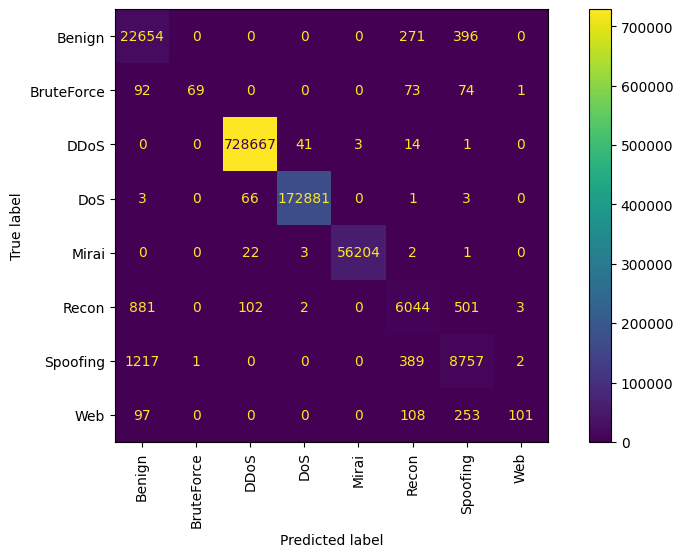

In [71]:
%%time

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs))
])

test_model(*baseline_df, model)

# Model

In [7]:
def get_attack_map(attack_category, layer_attacks):
    return {
        attack: attack if attack in layer_attacks else 'Benign'
        for attack in attack_category
    }

## First Layer - DDoS / DoS / Mirai

In [8]:
first_layer = {'DDoS', 'DoS', 'Mirai'}

first_layer_map = get_attack_map(attack_category, first_layer)

In [9]:
%%time

df_first_layer = get_train_test_split(
    df_refined.assign(first_layer_target=df.general_label.map(first_layer_map).astype('category')),
    refined_features_list,
    target='first_layer_target',
    sample_size=2_000_000,
    train_frac=0.50
)

CPU times: user 11.4 s, sys: 2.72 s, total: 14.1 s
Wall time: 14.1 s


Training dataset size: 1.0M (50.0%).
Test dataset size: 1.0M (50.0%).
Execution time (Model fit): 0:00:20.889046
Execution time (Predict): 0:00:04.078148
              precision    recall  f1-score   support

      Benign      1.000     0.998     0.999     42289
        DDoS      1.000     1.000     1.000    728042
         DoS      1.000     1.000     1.000    172933
       Mirai      1.000     0.999     1.000     56736

    accuracy                          1.000   1000000
   macro avg      1.000     0.999     1.000   1000000
weighted avg      1.000     1.000     1.000   1000000

CPU times: user 8min 6s, sys: 5.25 s, total: 8min 11s
Wall time: 2min 32s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=40))])

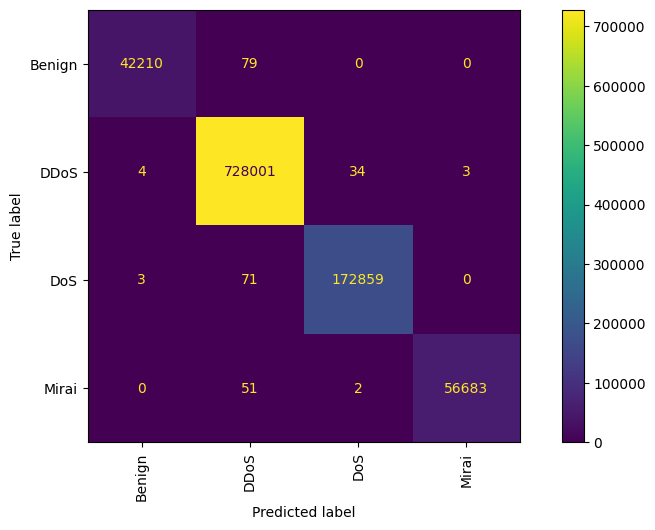

In [18]:
%%time

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(class_weight='balanced', n_jobs=n_jobs))
])

test_model(*df_first_layer, model)

Training dataset size: 1.0M (50.0%).
Test dataset size: 1.0M (50.0%).
Execution time (Model fit): 0:00:11.551702
Execution time (Predict): 0:00:03.752509
              precision    recall  f1-score   support

      Benign      0.999     1.000     0.999     42006
        DDoS      1.000     1.000     1.000    728020
         DoS      0.999     1.000     0.999    173805
       Mirai      1.000     1.000     1.000     56169

    accuracy                          1.000   1000000
   macro avg      1.000     1.000     1.000   1000000
weighted avg      1.000     1.000     1.000   1000000

CPU times: user 5min 45s, sys: 1.75 s, total: 5min 46s
Wall time: 2min 23s


Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(class_weight='balanced', n_jobs=40,
                                verbose=0))])

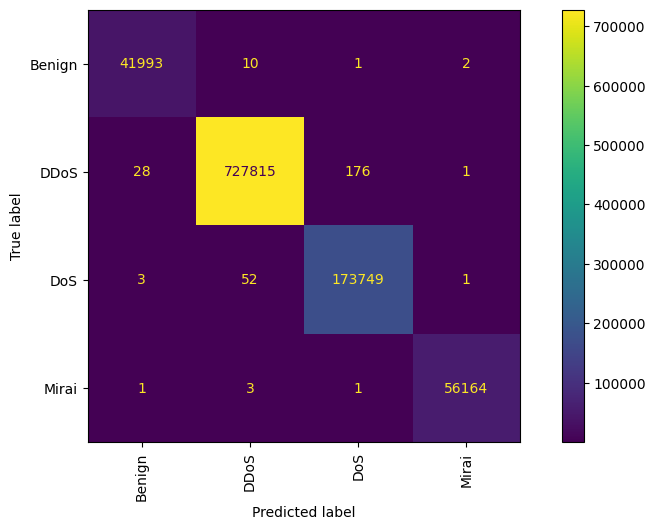

In [92]:
%%time

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(class_weight='balanced', n_jobs=n_jobs, verbose=0))
])

test_model(*df_first_layer, model)

## Second Layer - Spoofing / Recon / Web / Brute Force

In [28]:
%%time

second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce', 'Benign'}

df_second_layer = get_train_test_split(
    df_refined[df_refined['general_label'].isin(second_layer)],
    refined_features_list,
    target='general_label',
    train_frac=0.80
)

CPU times: user 1 s, sys: 304 ms, total: 1.31 s
Wall time: 1.3 s


Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
Execution time (Model fit): 0:00:52.341178
Execution time (Predict): 0:00:02.056981
              precision    recall  f1-score   support

      Benign      0.929     0.980     0.954    219566
  BruteForce      0.991     0.612     0.757      2616
       Recon      0.912     0.861     0.886     70611
    Spoofing      0.928     0.881     0.904     97793
         Web      0.980     0.526     0.684      4846

    accuracy                          0.926    395432
   macro avg      0.948     0.772     0.837    395432
weighted avg      0.927     0.926     0.925    395432



Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(n_jobs=40))])

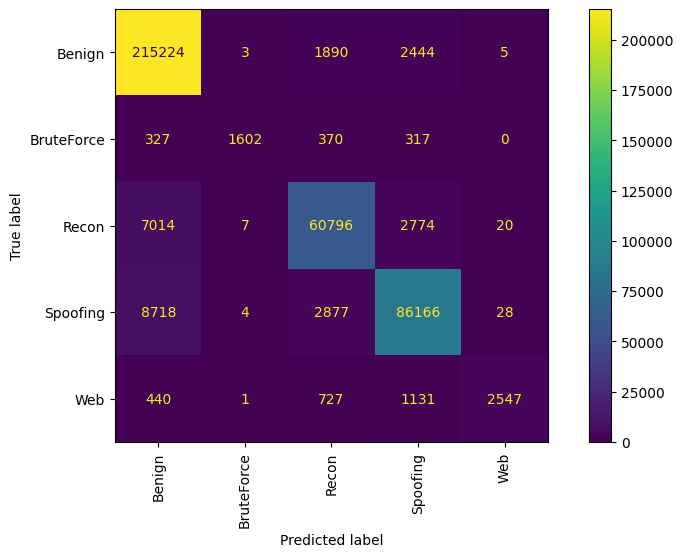

In [29]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(n_jobs=n_jobs))
])

test_model(*df_second_layer, model)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5058
[LightGBM] [Info] Number of data points in the train set: 1581725, number of used features: 38
[LightGBM] [Info] Start training from score -0.587909
[LightGBM] [Info] Start training from score -5.019861
[LightGBM] [Info] Start training from score -1.717459
[LightGBM] [Info] Start training from score -1.403435
[LightGBM] [Info] Start training from score -4.371389
Execution time (Model fit): 0:00:21.592358
Execution time (Predict): 0:00:01.737721
              precision    recall  f1-score   support

      Benign      0.916     0.976     0.945    219566
  BruteForce      0.822     0.615     0.703      2616
       Recon      0.900     0.847     0.873     70611
  

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(n_jobs=40))])

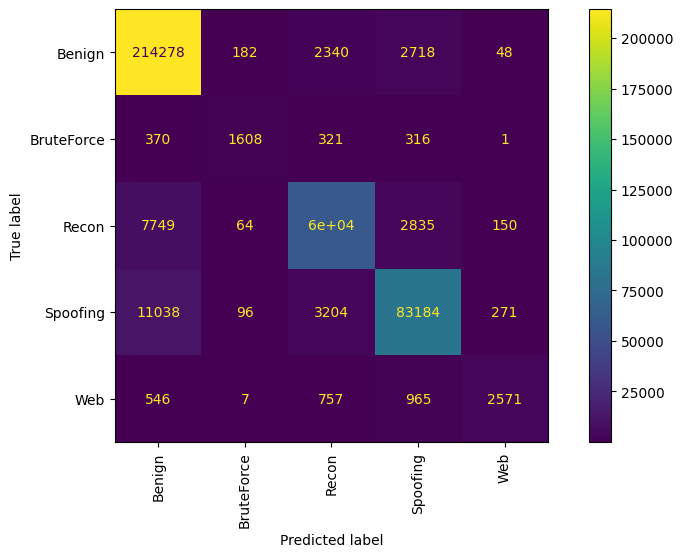

In [30]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(n_jobs=n_jobs))
])

test_model(*df_second_layer, model)

### Test

/tmp/ipykernel_1713453/1783205148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].cat.remove_unused_categories()


Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5058
[LightGBM] [Info] Number of data points in the train set: 1581725, number of used features: 38
[LightGBM] [Info] Start training from score -0.587909
[LightGBM] [Info] Start training from score -5.019861
[LightGBM] [Info] Start training from score -1.717459
[LightGBM] [Info] Start training from score -1.403435
[LightGBM] [Info] Start training from score -4.371389
Execution time (Model fit): 0:00:21.711525
Execution time (Predict): 0:00:01.775889
              precision    recall  f1-score   support

      Benign      0.916     0.976     0.945    219566
  BruteForce      0.822     0.615     0.703      2616
       Recon      0.900     0.847     0.873     70611
  

Pipeline(steps=[('scaler', StandardScaler()), ('model', LGBMClassifier())])

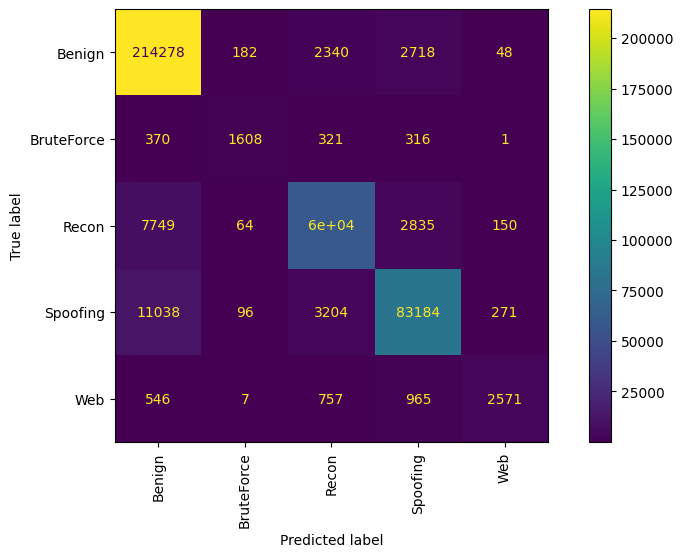

In [59]:

second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

df_second_layer_test = get_train_test_split(
    df_refined[df_refined['general_label'].isin(second_layer | {'Benign'})],
    refined_features_list,
    target='general_label',
    train_frac=0.80
)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(n_jobs=n_jobs))
])

test_model(*df_second_layer_test, model)

/tmp/ipykernel_1713453/1783205148.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = df[target].cat.remove_unused_categories()


Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063806 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5058
[LightGBM] [Info] Number of data points in the train set: 1581725, number of used features: 38
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
Execution time (Model fit): 0:00:22.803597
Execution time (Predict): 0:00:01.685321
              precision    recall  f1-score   support

      Benign      0.955     0.922     0.938    219566
  BruteForce      0.167     0.864     0.281      2616
       Recon      0.928     0.802     0.860     70611
  

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LGBMClassifier(class_weight='balanced'))])

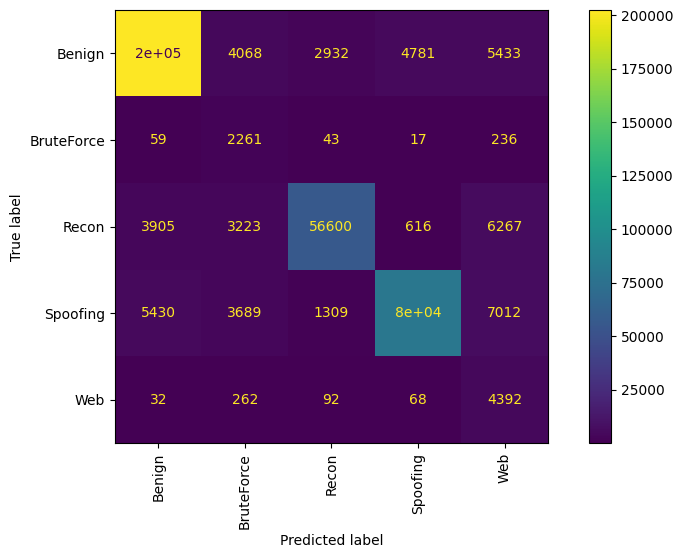

In [60]:
from lightgbm import LGBMClassifier

second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce'}

df_second_layer_test = get_train_test_split(
    df_refined[df_refined['general_label'].isin(second_layer | {'Benign'})],
    refined_features_list,
    target='general_label',
    train_frac=0.80
)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(class_weight='balanced'))
])

test_model(*df_second_layer_test, model)

Training dataset size: 1.6M (80.0%).
Test dataset size: 395.4k (20.0%).
Execution time (Model fit): 0:33:02.759810
Execution time (Predict): 0:00:27.111834
              precision    recall  f1-score   support

      Benign      0.929     0.981     0.954    219566
  BruteForce      0.991     0.612     0.757      2616
       Recon      0.914     0.862     0.887     70611
    Spoofing      0.928     0.881     0.904     97793
         Web      0.976     0.525     0.683      4846

    accuracy                          0.927    395432
   macro avg      0.948     0.772     0.837    395432
weighted avg      0.927     0.927     0.925    395432



Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier(n_estimators=200))])

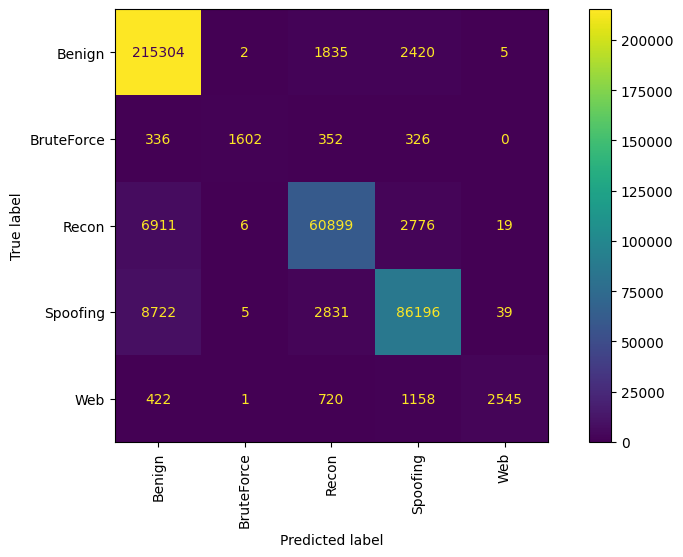

In [11]:
from lightgbm import LGBMClassifier

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier())
])

test_model(*df_second_layer, model)

In [50]:
from xgboost import XGBClassifier


second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce'}
test_df = df_refined[df_refined['general_label'].isin(second_layer | {'Benign'})]
test_df['test_label'] = test_df.general_label.cat.code

df_second_layer_test = get_train_test_split(
    df_refined[df_refined['general_label'].isin(second_layer | {'Benign'})],
    refined_features_list,
    target='test_label',
    train_frac=0.02
)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(enable_categorical=True))
])

test_model(*df_second_layer_test, model)

/tmp/ipykernel_1713453/311876747.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['test_label'] = test_df.general_label.cat.codes


Training dataset size: 39.5k (2.0%).
Test dataset size: 1.9M (98.0%).


TypeError: LabelEncoder.fit_transform() takes 2 positional arguments but 3 were given

In [50]:
from xgboost import XGBClassifier


second_layer = {'Spoofing', 'Recon', 'Web', 'BruteForce'}
test_df = df_refined[df_refined['general_label'].isin(second_layer | {'Benign'})]
test_df['test_label'] = test_df.general_label.cat.code

df_second_layer_test = get_train_test_split(
    df_refined[df_refined['general_label'].isin(second_layer | {'Benign'})],
    refined_features_list,
    target='test_label',
    train_frac=0.02
)

model = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(enable_categorical=True))
])

test_model(*df_second_layer_test, model)

/tmp/ipykernel_1713453/311876747.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['test_label'] = test_df.general_label.cat.codes


Training dataset size: 39.5k (2.0%).
Test dataset size: 1.9M (98.0%).


TypeError: LabelEncoder.fit_transform() takes 2 positional arguments but 3 were given